In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import numpy as np
import torch.nn as nn
import torchvision.models as models
import os
BATCH_SIZE = 8
MODEL_PATH = './resnet50_ddp.pt'
MODEL_NAME = 'resnet50'
NUM_CLASSES = 4
IMAGE_SIZE = 224



/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
ROOT_DIR = './data/images/'
CSV_PATH = './data/database/Tuberculosis/'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs,512),
                        nn.ReLU(),
                        nn.Dropout(p=0.3),
                        nn.Linear(512,2))

model = model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Generating a batch of images for inference

In [5]:
from torchvision import datasets
transform = transforms.Compose([transforms.Resize(size=(224,224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
covid_19_dataset = datasets.ImageFolder('./data/database',transform=transform)

In [6]:
#For test
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


batch_size = 4
# percentage of training set to use as validation
test_size = 0.2
valid_size = 0.1
num_data = len(covid_19_dataset)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

#For Valid
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Dataloader -> Set pin_memory=True and num_workers=8
train_dl = DataLoader(covid_19_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=4,
                      pin_memory=True,
                      sampler=train_sampler)
valid_dl = DataLoader(covid_19_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=4,
                      pin_memory=True,
                     sampler=test_sampler)

In [7]:
count=0
for x,y in train_dl:
    input_batch_chw = x
    input_batch_gpu = input_batch_chw.to("cuda")

    input_batch_gpu.shape
    count+=1
    
print(count)

378


## FP32 Prediction Performance

In [8]:
# Warm-up
with torch.no_grad():
    predictions = np.array(model(input_batch_gpu).cpu())
predictions.shape

(8, 2)

In [9]:
%%timeit

with torch.no_grad():
    preds = np.array(model(input_batch_gpu).cpu())

6.99 ms ± 745 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## FP16 Prediction Performance

In [10]:
model_fp32_16 = model.half()
input_half = input_batch_gpu.half()

In [11]:
# Warm-up
with torch.no_grad():
    preds = np.array(model_fp32_16(input_half).cpu()) # Warm Up
preds.shape

(8, 2)

In [12]:
%%timeit

with torch.no_grad():
    preds = np.array(model_fp32_16(input_half).cpu())

6.94 ms ± 67.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Running Inference

In [13]:
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs,512),
                        nn.ReLU(),
                        nn.Dropout(p=0.3),
                        nn.Linear(512,2))

model = model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
class PlantPath(Dataset):
    def __init__(self,csv_path):
        self.csv_path = csv_path
        self.csv_file = pd.read_csv(self.csv_path)
        self.x = self.csv_file['image_id']
        self.y = self.csv_file['label']
        
    def __len__(self):
        return len(self.x)

    def transform(self, image):
        trans = transforms.Compose([
                transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean = (0.485, 0.456, 0.406),
                                     std = (0.229, 0.224, 0.225))
            ])
        return trans(image)
    
    def __getitem__(self,idx): #File Name --> Preprocessed 3-D Tensor
        fname = self.x.iloc[idx]        
        label = self.y.iloc[idx]
        image = Image.open(fname)
        image = self.transform(image)
        return image, label #[3,224,224], [0-3] 

In [26]:
val_data = PlantPath(CSV_PATH)
dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)

IsADirectoryError: [Errno 21] Is a directory: './data/database/Tuberculosis/'

In [16]:
def eval (model_fp32, dataloader):    

    gt_all = None
    pred_all = None
    i=1
    for (img, gt) in dataloader:

        img, gt = img.to(device), gt.to(device)
        
        out = model(img).cpu()

        out = nn.functional.softmax(out, dim=1).detach().cpu()

        gt_all = np.concatenate((gt_all, gt.detach().cpu()), axis=0) if gt_all is not None else gt.detach().cpu()
        pred_all = np.concatenate((pred_all, out), axis=0) if pred_all is not None else out
        i=i+1
    return {
        "gt" : gt_all ,
        "pred" : np.argmax(pred_all, axis=1)
    }

In [ ]:
data_pytorch_model_fp32 = eval(model, dataloader)

In [19]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 32.5 MB/s eta 0:00:01


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,7))
fig_ = sns.heatmap(confusion_matrix(data_pytorch_model_fp32['gt'], data_pytorch_model_fp32['pred']), 
                   annot=True, cmap='Spectral', fmt='g').get_figure()
plt.show()

NameError: name 'data_pytorch_model_fp32' is not defined

<Figure size 720x504 with 0 Axes>

Plot Confusion Matrix

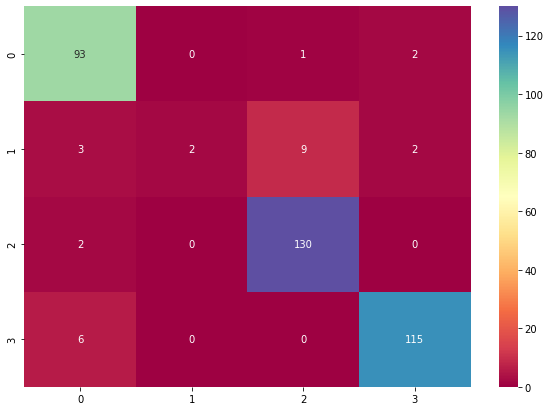

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,7))
fig_ = sns.heatmap(confusion_matrix(data_pytorch_model_fp32['gt'], data_pytorch_model_fp32['pred']), 
                   annot=True, cmap='Spectral', fmt='g').get_figure()
plt.show()